## Exercises

E01: train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?

E02: split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?

E03: use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?

E04: we saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?

E05: look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?

In [2]:
import matplotlib.pyplot as plt, torch.nn.functional as F, torch, numpy
words = open('names.txt').read().splitlines()

## E01 - build a nn trigram model 
I will use a NN torch tensor as a NN. The NN will take 54 inputs ,2 chars from one of 27 values, provided as a one hot encoded vector. Steps are:
1. setup imports
2. use words to populate xs and ys training sets this will required itos, stoi, and a way to get the first 2 chars as input, store as a [x,2] xs tensor
3. generate xenc by concating 2 chars as one hot encoded tensors, so 54 inputs
4. setup W as 54,27. 54 inputs resulting in 27 outputs logits
5. calculate the prob distribution by: convert output logits, to counts using exp(), normalise to a prob distribution (softmax)
6. calculate the loss against the training set: work out prob for each training example, using expected output, take log, mean, for log liklihood and nll. 
7. add to loss the regularisation, pull to lower weights, to avoid inf nll and simpler model?
8. setup backward pass and weight update
9. run in loop and validate loss improvements
10. use trained model to generate names

In [258]:
words[:4]

['emma', 'olivia', 'ava', 'isabella']

In [259]:
# create a training set of xs and ys, xs will be a tuple of two input
# create a nn with 27 x 2 inputs and 27 outputs

# setup
letters = sorted(['.'] + list(set(''.join(words))))
itos = {idx:ch for idx, ch in enumerate(letters)}
stoi = {v:k  for k,v in itos.items()} 

# populate training set
xs, ys = [],[]
# for w in words[:5]:
for w in words:
    chs = ['.'] * 2 + list(w) + ['.']
    for ch1, ch2, ch3 in (zip(chs, chs[1:], chs[2:])):
        ix1, ix2, ix3 = stoi[ch1], stoi[ch2], stoi[ch3]
        # print(ch1, ch2, ch3)
        xs.append((ix1, ix2))
        ys.append(ix3)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

xs.shape, ys.shape

(torch.Size([228146, 2]), torch.Size([228146]))

In [260]:
# setup inputs
xs_1 = F.one_hot(xs[:,0], num_classes=27).float()
xs_2 = F.one_hot(xs[:,1], num_classes=27).float()
xenc = torch.cat((xs_1, xs_2), dim=1) 
num = xs.shape[0]

In [263]:
# initialise an nn model
g = torch.Generator().manual_seed(2147483647)
W = torch.rand((54,27),  generator=g, requires_grad=True)
W.shape

torch.Size([54, 27])

In [264]:
LEARN_RATE = 25
N_ITER = 250
REG_FACTOR = 0.001

losses=[]
# train model 
for k in range(N_ITER):
    # forward pass
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)
    loss = -probs[torch.arange(num),ys].log().mean() + REG_FACTOR*(W**2).mean()
    losses.append(loss.item())
    if k % 50 == 0:
        print(f"{k:4}: {loss.item():.4f}")
    
    # backward pass
    W.grad = None
    loss.backward()
    
    # update
    W.data += -LEARN_RATE * W.grad # opposite direction to grad

print(f"final loss after {N_ITER}:  {losses[-1]:.4f}")


   0: 3.4338
  50: 2.4083
 100: 2.3761
 150: 2.3638
 200: 2.3572
final loss after 250:  2.3533


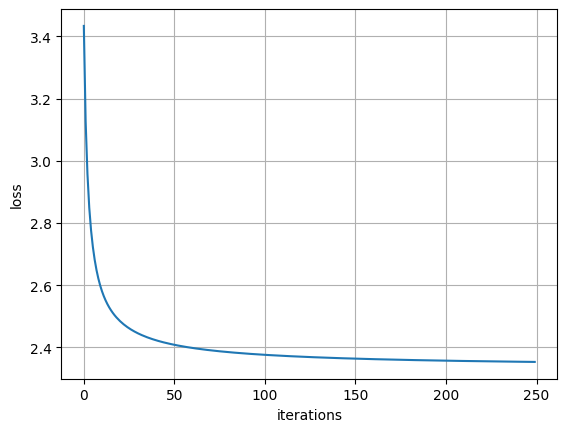

In [265]:
plt.ylabel("loss")
plt.xlabel("iterations")
plt.grid()
plt.plot(losses);

In [36]:
# min loss (LEARNRATE:25, N_ITER: 100,REG_FACTOR: 0.001) : 2.341

tensor(3.5756, grad_fn=<NegBackward0>)

In [271]:
# generate new names
for _ in range(10):
    out = []
    ix1, ix2 = 0, 0
    while True:
        xs_1 = F.one_hot(torch.tensor([ix1]), num_classes=27).float()
        xs_2 = F.one_hot(torch.tensor([ix2]), num_classes=27).float()
        xenc = torch.cat((xs_1, xs_2), dim=1) 
        logits = xenc @ W
        counts = logits.exp()
        p = counts / counts.sum(1, keepdim=True)
        ix1 = ix2
        ix2 = torch.multinomial(p, num_samples = 1, replacement=True, generator=g ).item()
        out.append(itos[ix2])
        if itos[ix2] == '.':
            break
    print(''.join(out))

ia.
tangepusanlet.
lineyn.
rnaadenha.
lachellia.
jjahemyadriynarioni.
dixanabyna.
bjanai.
ch.
kion.


In [39]:
x = F.one_hot(torch.tensor([0]), num_classes=27).float()
xenc = torch.cat((x,x), dim=1)
logits = xenc @ W
W.shape

torch.Size([54, 27])

## E02 - training set split loss against bigram and trigram models

Train the bigram and trigram model on 80% of data set and eval on the test (10%) and dev (10%) splits
1. build training sets
2. split them into train, dev, test
3. train nn model using training sets
4. validate loss for train, dev and test

do for bigram and trigram models

### Bigram NN - calculate loss for split dataset
training, dev, test datasets

In [265]:
chars = sorted(['.'] + list(set(''.join(words))))
itos = {idx: c for idx, c in enumerate(chars)}
stoi = {v:k for k,v in itos.items()}

xs, ys = [],[]

# for w in words[:5]:
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        xs.append(stoi[ch1])
        ys.append(stoi[ch2])

xs = torch.tensor(xs)
ys = torch.tensor(ys)

xs.shape, ys.shape

(torch.Size([228146]), torch.Size([228146]))

In [13]:
# split dataset into train, dev and test sets
def split_dataset(ds):
    idx = torch.randperm(ds.size(0))
    train_size = int(0.8 * len(idx))
    dev_size = int(0.1 * len(idx))
    x, y = train_size, train_size + dev_size

    return ds[:x],ds[x:y],ds[y:]

In [267]:
xs_train, xs_dev, xs_test = split_dataset(xs)
ys_train, ys_dev, ys_test = split_dataset(ys)

xs_train.shape, xs_test.shape, xs_dev.shape, ys_train.shape, ys_test.shape, ys_dev.shape

(torch.Size([182516]),
 torch.Size([22816]),
 torch.Size([22814]),
 torch.Size([182516]),
 torch.Size([22816]),
 torch.Size([22814]))

In [268]:
g = torch.Generator().manual_seed(2147483647)
W = torch.rand((27,27), generator=g, requires_grad=True)

In [269]:
##### train model 
LEARN_RATE = 25
N_ITER = 250
REG_FACTOR = 0.001

xenc = F.one_hot(xs_train, num_classes=27).float()
xs_num = xs_train.shape[0]
losses = []

for k in range(N_ITER):
    # forward pass
    logits = xenc @ W
    counts = logits.exp()
    p = counts / counts.sum(1, keepdim=True)
    loss = -p[torch.arange(xs_num), ys_train].log().mean() + REG_FACTOR*(W**2).mean()

    if k % 25 == 0:
        print(f"{k:4}: {loss.item():.4f}")
    losses.append(loss.item())

    # backward pass
    W.grad = None
    loss.backward()

    # update
    W.data += -LEARN_RATE*W.grad

print(f"result: {N_ITER} iterations final loss: {losses[-1]:.4f}")
    

   0: 3.3583
  25: 2.5581
  50: 2.4958
  75: 2.4730
 100: 2.4612
 125: 2.4540
 150: 2.4492
 175: 2.4458
 200: 2.4432
 225: 2.4412
result: 250 iterations final loss: 2.4397


In [10]:
# calculate the loss against the test and dev sets

def calc_loss(xs, ys, W):
    xenc = F.one_hot(xs, num_classes=27).float()    
    logits = xenc @ W
    counts = logits.exp()
    p = counts / counts.sum(1, keepdim=True)
    loss = -p[torch.arange(xs.shape[0]), ys].log().mean()
    
    return loss.item()

In [271]:
# Bigram 
print(f"train set loss: {calc_loss(xs_train, ys_train, W):.4f}") # model above include regularisation
print(f"dev set loss: {calc_loss(xs_dev, ys_dev, W):.4f}")
print(f"test set loss: {calc_loss(xs_test, ys_test, W):.4f}")

train set loss: 2.4378
dev set loss: 2.6056
test set loss: 2.6091


### Trigram NN - example calculating loss for split dataset

In [6]:
chars = sorted(['.'] + list(set(''.join(words))))
itos = {idx: c for idx, c in enumerate(chars)}
stoi = {v:k for k,v in itos.items()}

xs, ys = [],[]

for w in words:
    chrs = ['.']* 2 + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chrs, chrs[1:], chrs[2:]):
        # print(ch1, ch2, ch3)
        xs.append((stoi[ch1], stoi[ch2]))
        ys.append(stoi[ch3])

xs = torch.tensor(xs)
ys = torch.tensor(ys)

xs.shape, ys.shape

(torch.Size([228146, 2]), torch.Size([228146]))

In [252]:
# split dataset into train, dev and test sets
xs_train, xs_dev, xs_test = split_dataset(xs)
ys_train, ys_dev, ys_test = split_dataset(ys)

xs_train.shape, xs_test.shape, xs_dev.shape, ys_train.shape, ys_test.shape, ys_dev.shape

(torch.Size([182516, 2]),
 torch.Size([22816, 2]),
 torch.Size([22814, 2]),
 torch.Size([182516]),
 torch.Size([22816]),
 torch.Size([22814]))

In [253]:
g = torch.Generator().manual_seed(2147483647)
W = torch.rand((27*2, 27), generator = g, requires_grad=True)

In [254]:
# train model 
LEARN_RATE = 25
N_ITER = 250
REG_FACTOR = 0.001

# setup inputs
xs1 = F.one_hot(xs_train[:,0], num_classes=27).float()
xs2 = F.one_hot(xs_train[:,1], num_classes=27).float()
xenc = torch.concat((xs1, xs2), dim=1)

losses = []

for k in range(N_ITER):
    # forward pass    
    logits = xenc @ W
    counts = logits.exp()
    p = counts/counts.sum(1, keepdim=True)
    loss = -p[torch.arange(xs1.shape[0]),ys_train].log().mean() + REG_FACTOR*(W**2).mean()
    losses.append(loss.item())

    if k % 25 == 0:
        print(f"{k:4}:{loss.item():.4f}")

    # backward pass
    W.grad = None
    loss.backward()

    # update weights
    W.data += -LEARN_RATE * W.grad

print(f"result: {N_ITER} iterations final loss: {losses[-1]:.4f}")


   0:3.4320
  25:2.4283
  50:2.3747
  75:2.3535
 100:2.3420
 125:2.3346
 150:2.3295
 175:2.3257
 200:2.3228
 225:2.3205
result: 250 iterations final loss: 2.3187


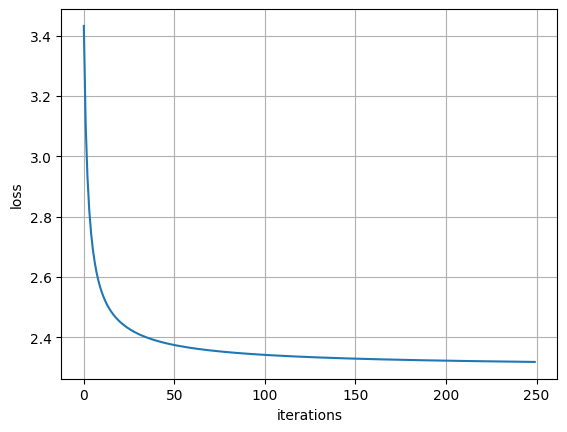

In [255]:
plt.ylabel("loss")
plt.xlabel("iterations")
plt.grid()
plt.plot(losses);

In [9]:
def calc_loss_trigram(xs, ys, W, reg=0):
    xs1 = F.one_hot(xs[:,0], num_classes=27).float()    
    xs2 = F.one_hot(xs[:,1], num_classes=27).float()    
    xenc = torch.concat((xs1,xs2), dim=1)
    logits = xenc @ W
    counts = logits.exp()
    p = counts / counts.sum(1, keepdim=True)
    loss = -p[torch.arange(xs.shape[0]), ys].log().mean() + reg * (W**2).mean()
    
    return loss.item()

In [264]:
#trigram
print(f"train set loss: {calc_loss_trigram(xs_train, ys_train, W):.4f}") # model above include regularisation
print(f"dev set loss: {calc_loss_trigram(xs_dev, ys_dev, W):.4f}")
print(f"test set loss: {calc_loss_trigram(xs_test, ys_test, W):.4f}")

train set loss: 2.3176
dev set loss: 2.5125
test set loss: 2.5220


### Conclusion
- dev and test loss are higher in both models than against the training set
- dev and test loss is similar given a model
- trigram trained model achieves better loss than bigram
- trigram has lower loss than bigram against dev and test sets


## E03 - tune smoothing or regularisation for trigram 

1. setup trigram
2. try out different regularisation factors when training model
3. see impact of reg factors against dev and test datasets - How good of a loss do you achieve?

In [57]:
# setup training sets
chars = sorted(['.'] + list(set(''.join(words))))
itos = {idx: c for idx, c in enumerate(chars)}
stoi = {v:k for k,v in itos.items()}

xs, ys = [],[]

for w in words:
    chrs = ['.']* 2 + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chrs, chrs[1:], chrs[2:]):
        # print(ch1, ch2, ch3)
        xs.append((stoi[ch1], stoi[ch2]))
        ys.append(stoi[ch3])

xs = torch.tensor(xs)
ys = torch.tensor(ys)

xs.shape, ys.shape

(torch.Size([228146, 2]), torch.Size([228146]))

In [55]:
# split dataset into train, dev and test sets
xs_train, xs_dev, xs_test = split_dataset(xs)
ys_train, ys_dev, ys_test = split_dataset(ys)

xs_train.shape

torch.Size([182516, 2])

In [21]:
# setup inputs
xs1 = F.one_hot(xs_train[:,0], num_classes=27).float()
xs2 = F.one_hot(xs_train[:,1], num_classes=27).float()
xenc = torch.concat((xs1, xs2), dim=1)

In [62]:
# train model 
LEARN_RATE = 25
N_ITER = 201
REG_STEPS = 25

loss_train, loss_dev, loss_test = [], [], []


for reg_factor in torch.linspace(0.0,1.0,REG_STEPS):
    # setup trigram and inputs
    g = torch.Generator().manual_seed(2147483647)
    W = torch.rand((27*2, 27), generator = g, requires_grad=True)
    
    for k in range(N_ITER):
        # forward pass    
        logits = xenc @ W
        counts = logits.exp()
        p = counts/counts.sum(1, keepdim=True)
        loss = -p[torch.arange(xs1.shape[0]),ys_train].log().mean() + reg_factor*(W**2).mean()
    
        if k % 200 == 0:
            print(f"{reg_factor:.4f}|{k:4}:{loss.item():.4f}")
    
        # backward pass
        W.grad = None
        loss.backward()
    
        # update weights
        W.data += -LEARN_RATE * W.grad

    train_loss = calc_loss_trigram(xs_train, ys_train, W, reg_factor)
    dev_loss = calc_loss_trigram(xs_dev, ys_dev, W, reg_factor)
    test_loss = calc_loss_trigram(xs_test, ys_test, W, reg_factor)

    loss_train.append((reg_factor, train_loss))
    loss_dev.append((reg_factor, dev_loss))
    loss_test.append((reg_factor, test_loss))

0.00000000|   0:3.4317
0.00000000| 200:2.3217
0.04166667|   0:3.4457
0.04166667| 200:2.3578
0.08333334|   0:3.4597
0.08333334| 200:2.3829
0.12500000|   0:3.4736
0.12500000| 200:2.4025
0.16666667|   0:3.4876
0.16666667| 200:2.4192
0.20833334|   0:3.5016
0.20833334| 200:2.4340
0.25000000|   0:3.5156
0.25000000| 200:2.4477
0.29166669|   0:3.5296
0.29166669| 200:2.4604
0.33333334|   0:3.5436
0.33333334| 200:2.4724
0.37500000|   0:3.5575
0.37500000| 200:2.4838
0.41666669|   0:3.5715
0.41666669| 200:2.4945
0.45833334|   0:3.5855
0.45833334| 200:2.5047
0.50000000|   0:3.5995
0.50000000| 200:2.5144
0.54166663|   0:3.6135
0.54166663| 200:2.5237
0.58333331|   0:3.6274
0.58333331| 200:2.5325
0.62500000|   0:3.6414
0.62500000| 200:2.5410
0.66666663|   0:3.6554
0.66666663| 200:2.5491
0.70833331|   0:3.6694
0.70833331| 200:2.5570
0.75000000|   0:3.6834
0.75000000| 200:2.5645
0.79166663|   0:3.6974
0.79166663| 200:2.5718
0.83333331|   0:3.7113
0.83333331| 200:2.5788
0.87500000|   0:3.7253
0.87500000|

In [59]:
loss_train, loss_dev, loss_test

([(tensor(0.), 2.3216443061828613),
  (tensor(0.5000), 2.5143990516662598),
  (tensor(1.), 2.6047399044036865)],
 [(tensor(0.), 2.516204357147217),
  (tensor(0.5000), 2.6823418140411377),
  (tensor(1.), 2.761134386062622)],
 [(tensor(0.), 2.5254061222076416),
  (tensor(0.5000), 2.6875486373901367),
  (tensor(1.), 2.7659637928009033)])

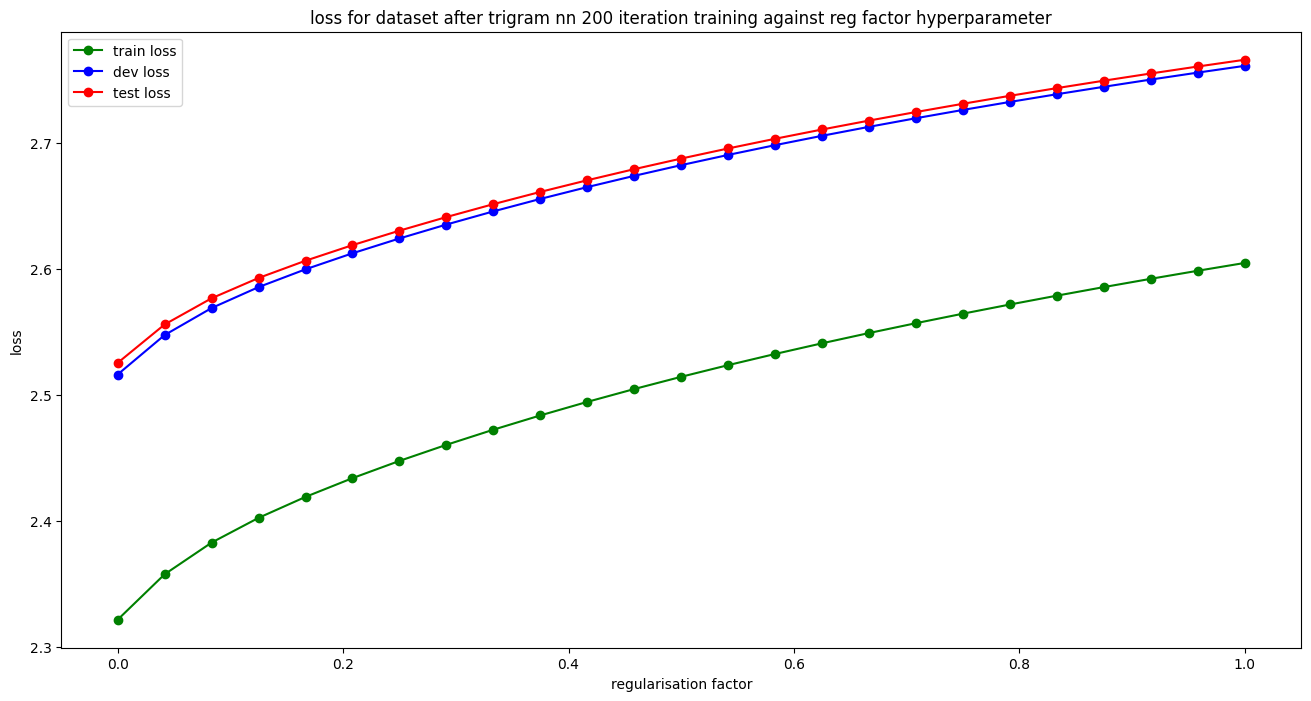

In [68]:
plt.figure(figsize=(16,8))
plt.plot(*zip(*loss_train), label="train loss", color='green', marker='o')
plt.plot(*zip(*loss_dev), label="dev loss", color='blue', marker='o')
plt.plot(*zip(*loss_test), label="test loss", color='red', marker='o')
plt.xlabel('regularisation factor')
plt.ylabel('loss')
plt.legend()
plt.title('loss for dataset after trigram nn 200 iteration training against reg factor hyperparameter')
plt.show()

#### Conclusions
- Training loss increase with regularisation and corresponding so does the loss against dev and test datasets.
- dev and test loss is similar and follow same curve closely to training
- dev and test loss is higher which means  it is overfitting and doesn't generalise that well to other datasets
- dev and test are representative of each other as loss is similar

In [3]:
torch.linspace(0.0,1.0,25)

tensor([0.0000, 0.0417, 0.0833, 0.1250, 0.1667, 0.2083, 0.2500, 0.2917, 0.3333,
        0.3750, 0.4167, 0.4583, 0.5000, 0.5417, 0.5833, 0.6250, 0.6667, 0.7083,
        0.7500, 0.7917, 0.8333, 0.8750, 0.9167, 0.9583, 1.0000])

## E04 - how to avoid use of one hot vectors

we saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?

In [390]:
xs = torch.tensor([2,1,0])
xenc = F.one_hot(xs, num_classes=5).float()
g = torch.Generator().manual_seed(1)
W = torch.rand((5,10), generator=g)

In [393]:
xenc @ W # (3,5) @ (5,10) -> (3,10)

tensor([[0.3138, 0.1980, 0.4162, 0.2843, 0.3398, 0.5239, 0.7981, 0.7718, 0.0112,
         0.8100],
        [0.6387, 0.5247, 0.6826, 0.3051, 0.4635, 0.4550, 0.5725, 0.4980, 0.9371,
         0.6556],
        [0.7576, 0.2793, 0.4031, 0.7347, 0.0293, 0.7999, 0.3971, 0.7544, 0.5695,
         0.4388]])

In [396]:
# we can just index the row directly, which does exactly the same as one hot encoding
# xenc @ W == W[xs]
torch.equal(xenc@W, W[xs])

True

In [397]:
(xenc @ W).shape, W[xs].shape

(torch.Size([3, 10]), torch.Size([3, 10]))

In [399]:
# watch out for indexing vs slicing. Indexing will return the row, so below 1D, whereas we want slicing 2D

W[xs].shape, W[0].shape, W[[0]].shape, W[[0,1]].shape

(torch.Size([3, 10]),
 torch.Size([10]),
 torch.Size([1, 10]),
 torch.Size([2, 10]))

In [414]:
# if we passed two one hot encoding concated together, then instead:
W = torch.rand((27+27,27), generator = g)
xs = torch.tensor([[10,14], [4,13], [8,10]])
xs1 = F.one_hot(xs[:,0], num_classes=27).float()
xs2 = F.one_hot(xs[:,1], num_classes=27).float()
xenc = torch.cat((xs1,xs2), dim=1)

torch.equal(xenc @ W, W[xs[:,0]] + W[27 + xs[:,1]])


True

## E05 - Using Cross Entropy

look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?



In [382]:
g = torch.Generator().manual_seed(1)
logits = torch.rand((3,5),generator=g)
logits

tensor([[0.7576, 0.2793, 0.4031, 0.7347, 0.0293],
        [0.7999, 0.3971, 0.7544, 0.5695, 0.4388],
        [0.6387, 0.5247, 0.6826, 0.3051, 0.4635]])

In [383]:
target = torch.tensor([0,3,2])
target

tensor([0, 3, 2])

In [384]:
counts = logits.exp()
p = counts / counts.sum(1, keepdim=True)
nll = -p[torch.arange(3), target].log().mean()
nll

tensor(1.4779)

In [385]:
# ce and nll are the same so cross entropy appears to allow us to do three
# steps in 1. also provides a parameters for model smoothing (label_smoothing)

ce = F.cross_entropy(logits, target)
ce, torch.equal(ce, nll)

(tensor(1.4779), False)

In [301]:
chars = sorted(['.'] + list(set(''.join(words))))
itos = {idx: c for idx, c in enumerate(chars)}
stoi = {v:k for k,v in itos.items()}

xs, ys = [],[]

for w in words:
    chrs = ['.']* 2 + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chrs, chrs[1:], chrs[2:]):
        # print(ch1, ch2, ch3)
        xs.append((stoi[ch1], stoi[ch2]))
        ys.append(stoi[ch3])

xs = torch.tensor(xs)
ys = torch.tensor(ys)

xs.shape, ys.shape

(torch.Size([228146, 2]), torch.Size([228146]))

In [386]:
# setup inputs
xs1 = F.one_hot(xs_train[:,0], num_classes=27).float()
xs2 = F.one_hot(xs_train[:,1], num_classes=27).float()
xenc = torch.concat((xs1, xs2), dim=1)

In [372]:
for _ in range(5):
    ix1, ix2 = 0,0
    out = []
    while True:
        logits = W[[ix1]] + W[[27+ix2]] # slice into the W directly without one hot encoding
        counts = logits.exp() # fake counts
        p = counts / counts.sum(1, keepdim=True)
        ix1 = ix2
        ix2 = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    
        if itos[ix2] == '.':
            break
        out.append(itos[ix2])
    print(''.join(out))

ore
violinn
nafraulei
nelitenan
ju
